In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import matplotlib.pyplot as plt
import warnings
import model_report as mr
import pickle
warnings.filterwarnings('ignore')
%matplotlib inline


In [24]:
file_info = "C:\\Users\\blgai\\OneDrive\\Documents\\School\\SMU\\Courses\\Fall 2021\\Capstone A\Data\\cleaned_chunked_v2.csv"
df = pd.read_csv(file_info, sep='\t')

In [25]:
df.groupby(df.category).size()

category
bu    11731
dr     1595
ed     3894
mk     8775
os     6789
sp     2535
sx     6557
dtype: int64

In [26]:
from sklearn.model_selection import train_test_split
#get 10% holdout set
train_corpus, holdout_corpus, train_label, holdout_label = train_test_split(df['clean_comp_nouns'], 
                                                                           df['category'],
                                                                           test_size=.10,random_state=1234)

#get 80% train and 20% test sets
train_corpus, test_corpus, train_label, test_label = train_test_split(train_corpus,
                                                                      train_label,
                                                                      test_size=.2225,random_state=1234) #.9 * .2225 = .20

train_corpus.shape, test_corpus.shape, holdout_corpus.shape

((29302,), (8386,), (4188,))

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

#build BOW features on train corpus
tv = TfidfVectorizer(use_idf=True, min_df=25,max_df=.9, norm="l2",smooth_idf=True)
tv_train_features = tv.fit_transform(train_corpus)
#transform test corpus into features
tv_test_features = tv.transform(test_corpus)
#transform holdout corpus into features
tv_holdout_features = tv.transform(holdout_corpus)

print('TFIDF model:> Train features shape:',tv_train_features.shape,'Test features shape:',tv_test_features.shape,'Holdout features shape:',tv_holdout_features.shape)

TFIDF model:> Train features shape: (29302, 17587) Test features shape: (8386, 17587) Holdout features shape: (4188, 17587)


In [28]:
#Let's find the top important features and analyze them

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X_opt=SelectKBest(chi2, k=4100)
tv_train_features_trimmed = X_opt.fit_transform(tv_train_features, train_label)
tv_train_features_trimmed.shape

(29302, 4100)

In [29]:
#create a data frame that includes all features and whether or not they are deemed important by feature_selection
feat_imp = pd.DataFrame(list(zip(tv.get_feature_names(),X_opt.get_support().tolist())),columns = ['Features','Important'])
feat_imp[feat_imp.Important == True]

,Features,Important
2,aaliyah,True
11,abby,True
15,abella,True
17,abigail,True
27,abroad,True
...,...,...
17540,zamnesia,True
17542,zapp,True
17554,zen,True
17569,zoe,True


In [30]:
#Now we can grab the important features so that we can select only the important features from the sparse matrix created by TfidfVectorizer
imp_Feats_array = np.array(feat_imp[feat_imp.Important == True].index)

In [31]:
#Now we can pull only the important features out of the original train, test, and holdout matrices
tv_train_features_sub = tv_train_features[:,imp_Feats_array]
tv_test_features_sub = tv_test_features[:,imp_Feats_array]
tv_holdout_features_sub = tv_holdout_features[:,imp_Feats_array]

#Examine the new shapes of the sub-selected features
print('TFIDF model:> Train features shape:',tv_train_features_sub.shape,'Test features shape:',tv_test_features_sub.shape,'Holdout features shape:',tv_holdout_features_sub.shape)

TFIDF model:> Train features shape: (29302, 4100) Test features shape: (8386, 4100) Holdout features shape: (4188, 4100)


In [32]:
#setting up the classifiers
clf1 = LogisticRegression(penalty='l2', max_iter=100,C=1,random_state=1234)
clf2 = svm.SVC(kernel='linear', C=1.0, random_state=1234)
clf3 = SGDClassifier(penalty='l2', learning_rate='optimal', loss='hinge', n_jobs=1, early_stopping=True, n_iter_no_change=5, verbose=1,random_state=1234)
clf4 = svm.SVC(kernel='rbf', C=1.0, random_state=1234)

#setting up the voting classifier
ensemble_clf = VotingClassifier(estimators=[('lr',clf1),('svm',clf2),('sgd',clf3),('svm_r',clf4)],voting='hard', weights=(1, 1, 2, 1))

In [33]:
#fit the ensemble
ensemble_clf = ensemble_clf.fit(tv_train_features_sub,train_label)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 30.71, NNZs: 3795, Bias: -0.756367, T: 26371, Avg. loss: 0.212422
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 29.80, NNZs: 3894, Bias: -0.738174, T: 52742, Avg. loss: 0.188178
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 29.50, NNZs: 3909, Bias: -0.770154, T: 79113, Avg. loss: 0.183494
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 29.36, NNZs: 3936, Bias: -0.742107, T: 105484, Avg. loss: 0.181987
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 29.30, NNZs: 3959, Bias: -0.740875, T: 131855, Avg. loss: 0.181120
Total training time: 0.07 seconds.
-- Epoch 6
Norm: 29.30, NNZs: 3962, Bias: -0.741231, T: 158226, Avg. loss: 0.180343
Total training time: 0.08 seconds.
Convergence after 6 epochs took 0.09 seconds
-- Epoch 1
Norm: 12.01, NNZs: 3084, Bias: -1.148003, T: 26371, Avg. loss: 0.011891
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 11.61, NNZs: 3284, Bias: -1.128004, T: 52742, Avg. loss: 0.009449
Total training time: 0.02 seconds.
-- Epoch

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.7s finished


In [34]:
ensemble_clf_score = ensemble_clf.score(tv_test_features_sub,test_label)
print('Test Accuracy:',ensemble_clf_score)

Test Accuracy: 0.8654901025518722


In [35]:
import model_evaluation_utils as meu
ensemble_clf_predictions = ensemble_clf.predict(tv_test_features_sub)
meu.get_metrics(true_labels=test_label,predicted_labels=ensemble_clf_predictions)

Accuracy: 0.8655
Precision: 0.867
Recall: 0.8655
F1 Score: 0.8659


In [36]:
unique_classes = list(set(test_label))
meu.display_classification_report(true_labels=test_label,predicted_labels=ensemble_clf_predictions,classes=unique_classes)

              precision    recall  f1-score   support

          ed       0.92      0.88      0.90       783
          os       0.85      0.80      0.82      1393
          mk       0.75      0.78      0.77      1709
          sp       0.90      0.89      0.90       494
          dr       0.99      0.91      0.95       307
          sx       0.99      0.99      0.99      1345
          bu       0.85      0.88      0.86      2355

    accuracy                           0.87      8386
   macro avg       0.89      0.87      0.88      8386
weighted avg       0.87      0.87      0.87      8386



Confusion matrix, without normalization
[[1110   19    2   11  162    2   87]
 [   4  691    0    9   25    0   54]
 [  13    1  278    0    8    2    5]
 [  13    8    0  438   29    2    4]
 [ 110   18    0   23 1333    1  224]
 [   1    0    0    1   11 1330    2]
 [  59   17    0    2  198    1 2078]]


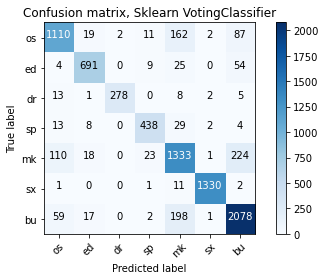

In [37]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test_label,ensemble_clf_predictions,labels=['os','ed','dr','sp','mk','sx','bu'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
mr.plot_confusion_matrix(cnf_matrix, classes=['os','ed','dr','sp','mk','sx','bu'],
                      title='Confusion matrix, Sklearn VotingClassifier')

In [38]:
df_test_results = pd.DataFrame(list(zip(test_corpus,test_label,ensemble_clf_predictions)),columns = ['terms','category','predicted_label'])
df_test_results['match'] = np.where(df_test_results['category']==df_test_results['predicted_label'],1,0)

In [39]:
rpt = mr.generate_report(df_test_results)
rpt

{'totalSamples': 8386,
 'overallAccuracy': 0.8654901025518722,
 'byCategory': {'sx': {'totalSamples': 1345, 'accuracy': 0.9888475836431226},
  'dr': {'totalSamples': 307, 'accuracy': 0.9055374592833876},
  'sp': {'totalSamples': 494, 'accuracy': 0.8866396761133604},
  'ed': {'totalSamples': 783, 'accuracy': 0.8825031928480205},
  'bu': {'totalSamples': 2355, 'accuracy': 0.8823779193205945},
  'os': {'totalSamples': 1393, 'accuracy': 0.7968413496051687},
  'mk': {'totalSamples': 1709, 'accuracy': 0.7799882972498537}}}

In [40]:
#let's look at the volume of misclassifications by category
df_test_results[df_test_results.match == 0].groupby('category').size()

category
bu    277
dr     29
ed     92
mk    376
os    283
sp     56
sx     15
dtype: int64

In [41]:
#let's look at some of the misclassifications to get an idea of why they were misclassified
pd.set_option('display.max_colwidth', None)
df_test_results[(df_test_results.predicted_label == 'sx') & (df_test_results.match == 0)]

terms  \
1787                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [42]:
#pickle the model
import pickle

filename = 'ensemble_comp_nouns_v1.sav'
pickle.dump(ensemble_clf,open(filename,'wb'))